## TODOs
- [ ] Check if QC works. Huge difference filtered vs unfiltered cells in script: 362 vs 2344
- [ ] Source helper functions
- [ ] If we use shift changes globally, implement on frag-file or region level

# Setup

In [59]:
import time

import os
import pandas as pd
import pysam
import anndata as ad
import re
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
from matplotlib import pyplot as plt

import sys

PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
SAMPLES = [f for f in os.listdir(DATA_PATH + 'outputs') if os.path.isdir(os.path.join(DATA_PATH + 'outputs', f))]
# SAMPLES = ['sSL0146_BrainO_R4_F_10xM_Multiome', 'sSL0136_BrainO_R3_B_10xM_Multiome', 'sSL0170_BrainO_R4_F_10xM_Multiome']
RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

sys.path.append(PROJECT_PATH + "/code")
from helpers.helpers import regex_get, get_anndata_coldata, ct_format

os.chdir(PROJECT_PATH)

### User input

In [60]:
# 0-based half open, code handles changes if needed
regions = {
    'CYC1': ['chr8', 144095039 - 101, 144095039 + 100 ], # Cytochrome C1 (+) chr8:144,095,039-144,097,525
    'RPL13': [ 'chr8', 120445402 - 101, 120445402 + 100], # Mitochondrial Ribosomal Protein L13 (-) chr8:120,380,761-120,445,402
    'MEF2C': ['chr5', 88904257 - 101, 88904257 + 100], # (-) chr5:88717117-88904257 1-based
    'SOX2': ['chr3', 181711925 - 101, 181711925 + 100], # (+) chr3:181,711,925-181,714,436 
    'LHX5': ['chr12', 113472280 - 101, 113472280 + 100] # (-) chr12:113,462,033-113,472,280
}

In [61]:
q_donors = [ 'melw', 'pelm', 'ualf', 'zoxy']
q_ct = ['Glia',  'Midbrain-EN', 'UL-EN']
q_ct = [ct_format(ct) for ct in q_ct]

In [62]:
min_frag_size = 10
max_frag_size = 200

# Functions

In [65]:
def create_profile(frags, region_name, region_start, region_end, include_counts=False, mode='ATAC', plus_correction=None, minus_correction=None):

    frags = frags.copy()
    
    if include_counts:
        # Count insertions as many as there are counts
        frags = frags.loc[frags.index.repeat(frags['counts'])].reset_index()
    
    cell_idx = np.linspace(0, len(frags) - 1, len(frags), dtype=int)
    # print(f'{region_name}\tstart: {region_start}\tend: {region_end}\tdiff: {region_end - region_start + 1}')
    # print(f'Min start: {min(frags["start"]) - region_start + 1}\nMin end: {min(frags["end"]) - region_start + 1}')
    
    # Account for Tn5 insertion shift
    
    if mode == 'ATAC':
        
        if plus_correction == None:
            plus_correction = 4
            
        if minus_correction == None:
            minus_correction = -5
        
        plus_correction = plus_correction - 4
        minus_correction = minus_correction + 5
        
    elif mode == 'manual':
        
        pass
    
    else:
        
        raise ValueError("Currently only ATAC-seq data accepted")
    
    
    # Create profiles
    
    if min(frags['start']) - region_start >= 0:
        # print('AHHH!')
        frags['start_0'] = frags['start'] - region_start + plus_correction
        frags['end_0'] = frags['end'] - region_start + minus_correction
        
        insertions = np.ones(len(frags)*2)
        row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
        # print(max(row_indices))
        # print(len(row_indices))
        col_indices = np.concatenate([cell_idx, cell_idx])
        
        profile_sm = csr_matrix((insertions, (row_indices, col_indices)),
                                shape = [max(row_indices) + 1 if max(row_indices) >= (region_end - region_start) else (region_end - region_start) + 1,
                                         len(frags)])

        # print(profile_sm.get_shape())
        # profile_sm = profile_sm[0: region_end - region_start + 1]
        profile_sm = profile_sm[0: region_end - region_start + 1 - 1]    # +1 cause 0-based indexing, -1 cause original region is 0-based half open indexed so we want to keep until a position before end
        # print(profile_sm.get_shape())

    else:

        # print('---')
        frags['start_0'] = frags['start'] - min(frags['start']) + plus_correction
        frags['end_0'] = frags['end'] - min(frags['start']) + minus_correction

        insertions = np.ones(len(frags)*2)
        row_indices = np.concatenate([np.array(frags['start_0']), np.array(frags['end_0'])])
        col_indices = np.concatenate([cell_idx, cell_idx])
        # print(f'max row_indices: {max(row_indices)}')
        # print(f'min row_indices: {min(row_indices)}')
        # print(f'len row_indices: {len(row_indices)}')
        profile_sm = csr_matrix((insertions, (row_indices, col_indices)),
                                shape = [max(row_indices) + 1 if max(row_indices) > (region_end - min(frags['start'])) else (region_end - min(frags['start'])) + 1,
                                # shape = [max(row_indices) + 1 if max(row_indices) > (region_end - min(frags['start'])) else (region_end - min(frags['start']) + 1) + 1,
                                         len(frags)])

        # print(profile_sm.get_shape())
        profile_sm = profile_sm[region_start - min(frags['start']) : region_end - min(frags['start']) + 1 - 1]  # +1 cause 0-based indexing, -1 cause original region is 0-based half open indexed so we want to keep until a position before end
        # print(profile_sm.get_shape())    

    profile = profile_sm.sum(axis=1).tolist()
    profile = [j for i in profile for j in i]
    # print('{}:\tLen: {}\tCounts: {}'.format(region_name, len(profile), sum(profile)))

    return profile, len(frags)

# Get metadata

In [63]:
cells_coldata, qc_cells, cell_types, samples, donors = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))

# Parse samples and gather fragments

In [35]:
st = time.time()

gathered_frags = {}


for r in regions.keys():
    
    frags = pd.DataFrame(columns=['chr', 'start', 'end', 'barcode', 'counts', 'sample', 'donor', 'donor_id', 'cell_type'])

    for s in SAMPLES:

        sample_path = os.path.join(DATA_PATH, 'outputs', s, s, 'outs/atac_fragments.tsv.gz')
        sample_name = regex_get(s, 'sample_name')

        tbx = pysam.TabixFile(sample_path, parser=pysam.asTuple())

        for row in tbx.fetch(regions[r][0], regions[r][1] + 1, regions[r][2]):  # Correct for indexing, tabix uses 1-based fully closed

            cell_id = '{}_{}'.format(row[3], sample_name)


            if cell_id in qc_cells:# and (int(row[2]) - int(row[1])) > min_frag_size and (int(row[2]) - int(row[1])) < max_frag_size:

                entry = {'chr': row[0],
                          'start': int(row[1]), # 0-based
                        #   'start': int(row[1]) + 1, # Make 1-based
                          'end': int(row[2]),   # half open
                          'barcode': row[3],
                          'counts': int(row[4]),
                          'sample': cells_coldata.loc[cell_id, 'sample'],
                          'donor': cells_coldata.loc[cell_id, 'donor'],
                          'donor_id': cells_coldata.loc[cell_id, 'donor_id'], 
                          'cell_type': cells_coldata.loc[cell_id, 'cell_type']}

                frags = frags._append(entry, ignore_index=True)

    gathered_frags[r] = frags

et = time.time()
print(f'Time elapsed: {et - st}')
          
# MEF2C promoter: 1 sample --> 2s
# MEF2C promoter: 3 samples --> 5s
# MEF2C promoter: All samples --> 204s
# MEF2C promoter: All samples --> 204s
# MEF2C, SOX2, LHX5 promoters: 3 samples --> 50
# MEF2C, SOX2, LHX5 promoters: All samples --> 2674s
# MEF2C, SOX2, LHX5, CYC1, RPL13: All samples --> 805-6828s = 13'- 17'

Time elapsed: 805.0787723064423


## Gathered fragment stats

In [36]:
print('Gene\t#frags\n')

for r in gathered_frags.keys():
    
    print('{}\t{}'.format(r, len(gathered_frags[r])))

Gene	#frags

CYC1	41265
RPL13	14623
MEF2C	0
SOX2	16980
LHX5	2531


# Create profiles

## Default

In [37]:
# Init dict
profiles = {}

for r in regions:
    
    profiles[r] = {}
    
    for d in donors:
        
        profiles[r][d] = {}
        
        for ct in cell_types:
            
            profiles[r][d][ct] = {}
            


for r in regions:

    for d in donors:

        for ct in cell_types:

            subset = (gathered_frags[r]['donor'] == d) & (gathered_frags[r]['cell_type'] == ct)
            
            if sum(subset) > 0:
                profiles[r][d][ct]['profile'], profiles[r][d][ct]['n_frags'] = create_profile(gathered_frags[r][subset], *regions[r])
            else:
                profiles[r][d][ct] = None

NameError: name 'create_profile' is not defined

## Count counts

In [11]:
# Init dict
profiles_counts = {}

for r in regions:
    
    profiles_counts[r] = {}
    
    for d in donors:
        
        profiles_counts[r][d] = {}
        
        for ct in cell_types:
            
            profiles_counts[r][d][ct] = {}
            


for r in regions:

    for d in donors:

        for ct in cell_types:

            subset = (gathered_frags[r]['donor'] == d) & (gathered_frags[r]['cell_type'] == ct)
            
            if sum(subset) > 0:
                profiles_counts[r][d][ct]['profile'], profiles_counts[r][d][ct]['n_frags'] = create_profile(gathered_frags[r][subset], *regions[r], include_counts=True)
            else:
                profiles_counts[r][d][ct] = None

## +4/-4

In [12]:
# Init dict
profiles_cbn = {}

for r in regions:
    
    profiles_cbn[r] = {}
    
    for d in donors:
        
        profiles_cbn[r][d] = {}
        
        for ct in cell_types:
            
            profiles_cbn[r][d][ct] = {}
            


for r in regions:

    for d in donors:

        for ct in cell_types:

            subset = (gathered_frags[r]['donor'] == d) & (gathered_frags[r]['cell_type'] == ct)
            
            if sum(subset) > 0:
                profiles_cbn[r][d][ct]['profile'], profiles_cbn[r][d][ct]['n_frags'] = create_profile(gathered_frags[r][subset], *regions[r], mode='ATAC', plus_correction=4, minus_correction=-4)
            else:
                profiles_cbn[r][d][ct] = None

## Profiles stats

In [13]:
# How many Nones?
n_nones = sum([(profiles[r][d][ct] == None) for r in profiles.keys() for d in donors for ct in cell_types])
total_groups = sum([True for r in profiles.keys() for d in donors for ct in cell_types])
print('Fraction of donor-cell_type groups without any fragments in region: {}'.format(round(n_nones / (total_groups), 2)))

Fraction of donor-cell_type groups without any fragments in region: 0.52


In [14]:
print("Insertions +- 100bp of TSS\tDonor\tCell type")

counts = []

for r in profiles.keys():

    for d in q_donors:

        for ct in q_ct:

            if profiles[r][d][ct]:

                counts.append([r, d, ct, int(np.sum(profiles[r][d][ct]['profile']))])

            else:

                counts.append([r, d, ct, 0])

counts_df = pd.DataFrame(counts, columns=['region', 'donor', 'cell_type', 'insertions'])
counts_df
counts_df = pd.pivot_table(counts_df, index=['donor', 'cell_type'], columns='region', values='insertions').reset_index()
counts_df.columns.name = None
counts_df

Insertions +- 100bp of TSS	Donor	Cell type


,donor,cell_type,CYC1,LHX5,MEF2C,RPL13,SOX2
0,melw,Glia,1,0,0,0,1
1,melw,Midbrain EN,228,10,0,47,46
2,melw,UL-EN,0,0,0,0,0
3,pelm,Glia,95,1,0,42,74
4,pelm,Midbrain EN,98,12,0,45,27
5,pelm,UL-EN,49,2,0,12,5
6,ualf,Glia,269,11,0,57,172
7,ualf,Midbrain EN,0,0,0,0,0
8,ualf,UL-EN,113,12,0,62,11
9,zoxy,Glia,15,0,0,3,7


In [15]:
print("Insertions +- 100bp of TSS\tDonor\tCell type")

counts = []

for r in profiles_counts.keys():

    for d in q_donors:

        for ct in q_ct:

            if profiles_counts[r][d][ct]:

                counts.append([r, d, ct, int(np.sum(profiles_counts[r][d][ct]['profile']))])

            else:

                counts.append([r, d, ct, 0])

counts_df = pd.DataFrame(counts, columns=['region', 'donor', 'cell_type', 'insertions'])
counts_df
counts_df = pd.pivot_table(counts_df, index=['donor', 'cell_type'], columns='region', values='insertions').reset_index()
counts_df.columns.name = None
counts_df

Insertions +- 100bp of TSS	Donor	Cell type


,donor,cell_type,CYC1,LHX5,MEF2C,RPL13,SOX2
0,melw,Glia,1,0,0,0,2
1,melw,Midbrain EN,349,11,0,68,67
2,melw,UL-EN,0,0,0,0,0
3,pelm,Glia,147,1,0,59,107
4,pelm,Midbrain EN,146,21,0,65,38
5,pelm,UL-EN,57,3,0,14,6
6,ualf,Glia,420,21,0,81,259
7,ualf,Midbrain EN,0,0,0,0,0
8,ualf,UL-EN,158,16,0,107,18
9,zoxy,Glia,16,0,0,4,7


In [16]:
print("Insertions +- 100bp of TSS\tDonor\tCell type")

counts = []

for r in profiles_cbn.keys():

    for d in q_donors:

        for ct in q_ct:

            if profiles_cbn[r][d][ct]:

                counts.append([r, d, ct, int(np.sum(profiles_cbn[r][d][ct]['profile']))])

            else:

                counts.append([r, d, ct, 0])

counts_df = pd.DataFrame(counts, columns=['region', 'donor', 'cell_type', 'insertions'])
counts_df
counts_df = pd.pivot_table(counts_df, index=['donor', 'cell_type'], columns='region', values='insertions').reset_index()
counts_df.columns.name = None
counts_df

Insertions +- 100bp of TSS	Donor	Cell type


,donor,cell_type,CYC1,LHX5,MEF2C,RPL13,SOX2
0,melw,Glia,1,0,0,0,1
1,melw,Midbrain EN,228,10,0,47,46
2,melw,UL-EN,0,0,0,0,0
3,pelm,Glia,95,1,0,42,74
4,pelm,Midbrain EN,98,12,0,45,27
5,pelm,UL-EN,49,2,0,12,5
6,ualf,Glia,269,11,0,57,172
7,ualf,Midbrain EN,0,0,0,0,0
8,ualf,UL-EN,113,12,0,62,11
9,zoxy,Glia,15,0,0,3,7


# Plot profiles

## Default

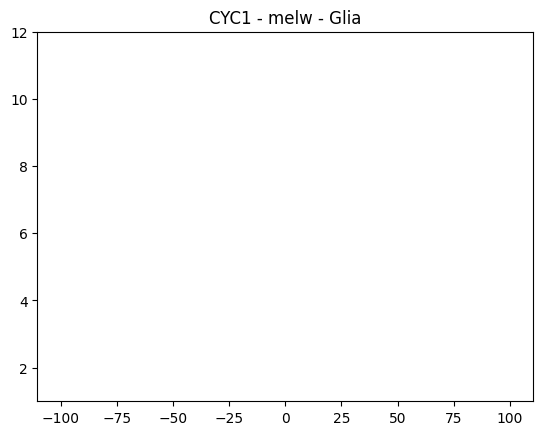

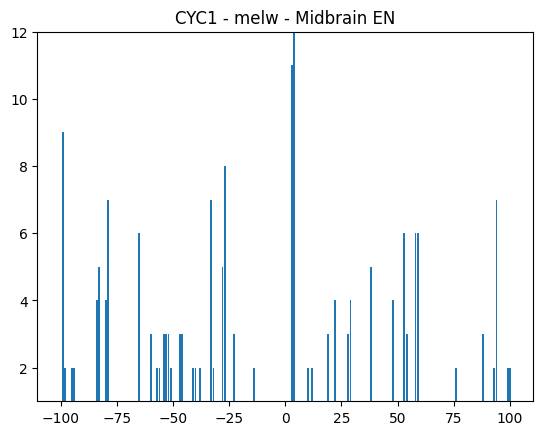

Region: CYC1, donor: melw, cell type: UL-EN --> No fragments found


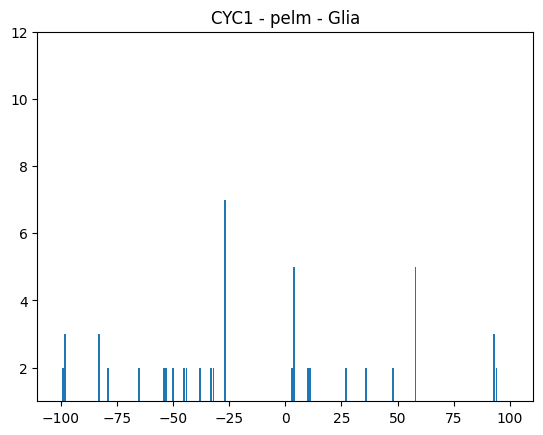

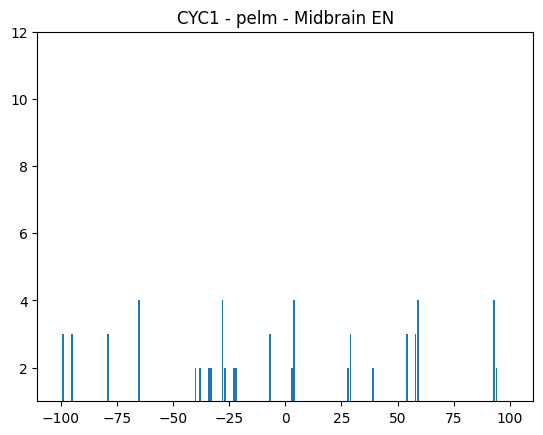

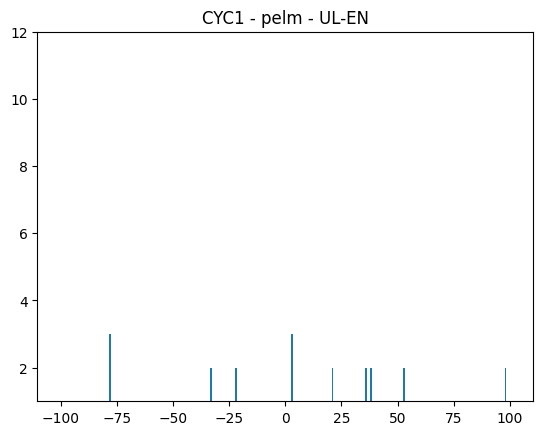

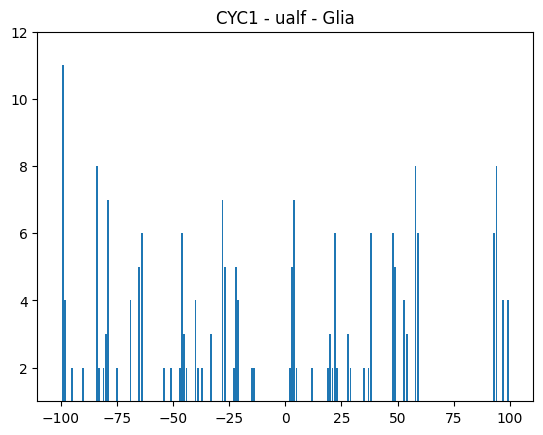

Region: CYC1, donor: ualf, cell type: Midbrain EN --> No fragments found


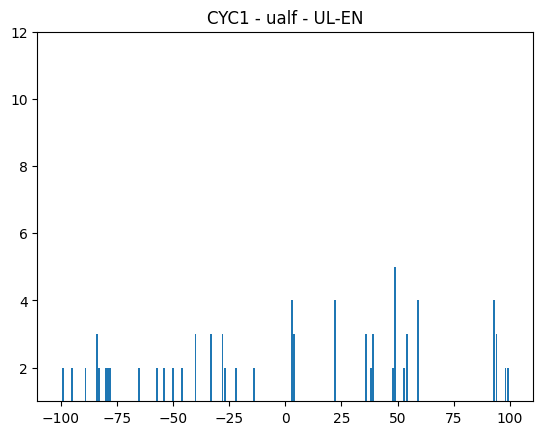

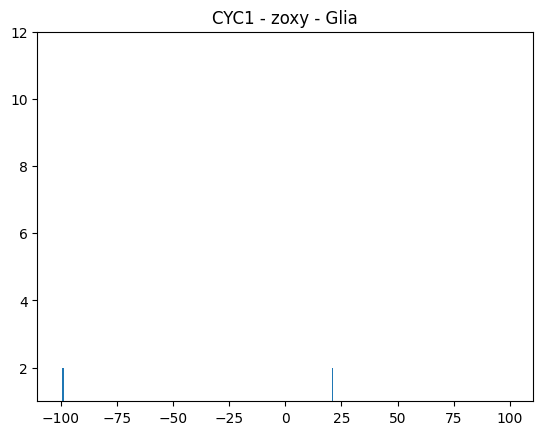

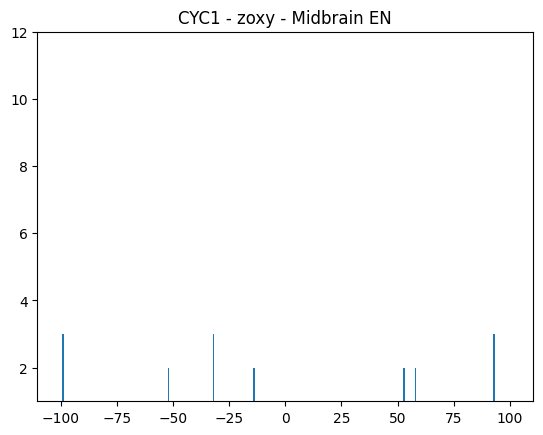

Region: CYC1, donor: zoxy, cell type: UL-EN --> No fragments found
Region: RPL13, donor: melw, cell type: Glia --> No fragments found


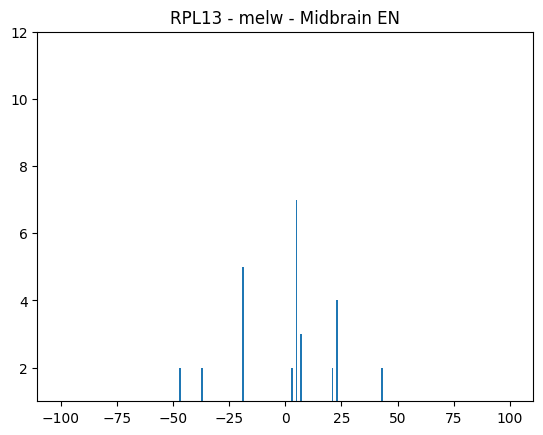

Region: RPL13, donor: melw, cell type: UL-EN --> No fragments found


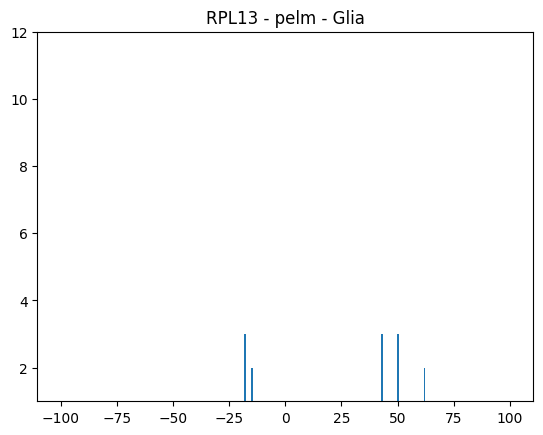

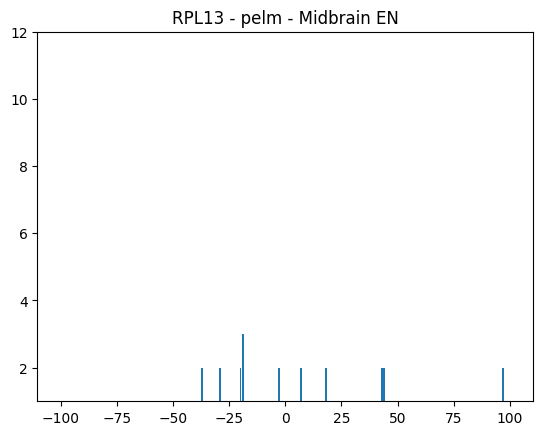

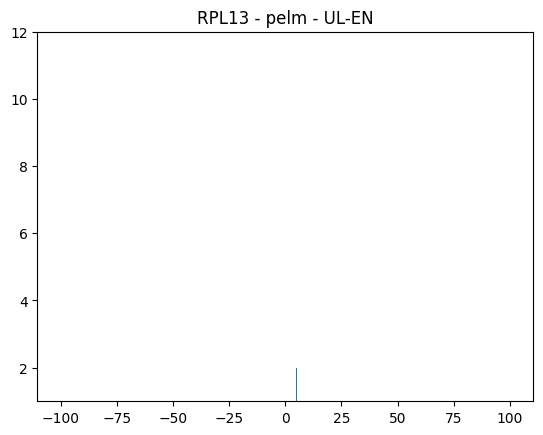

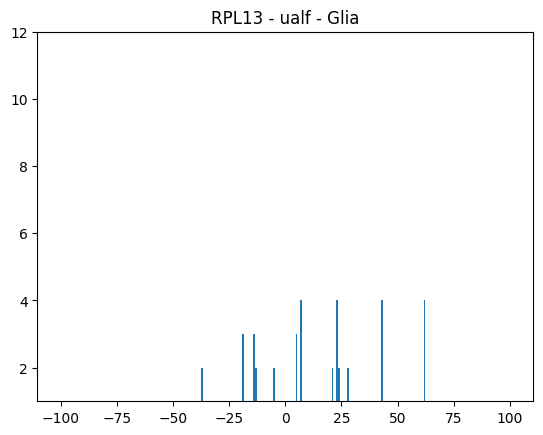

Region: RPL13, donor: ualf, cell type: Midbrain EN --> No fragments found


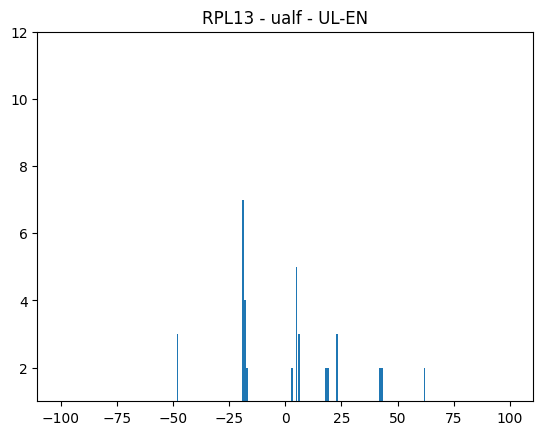

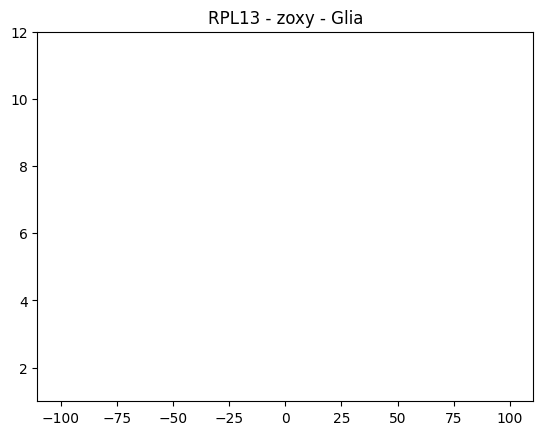

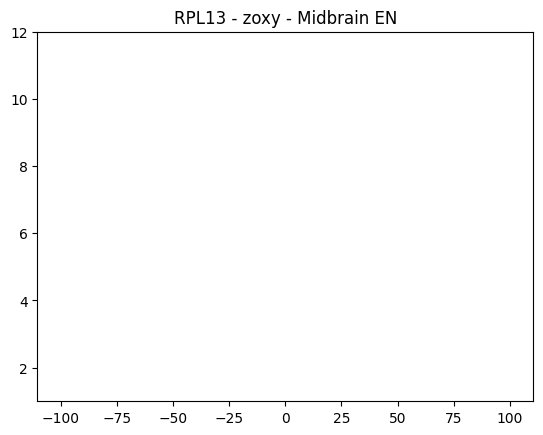

Region: RPL13, donor: zoxy, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: melw, cell type: Glia --> No fragments found
Region: MEF2C, donor: melw, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: melw, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: pelm, cell type: Glia --> No fragments found
Region: MEF2C, donor: pelm, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: pelm, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: ualf, cell type: Glia --> No fragments found
Region: MEF2C, donor: ualf, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: ualf, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: zoxy, cell type: Glia --> No fragments found
Region: MEF2C, donor: zoxy, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: zoxy, cell type: UL-EN --> No fragments found


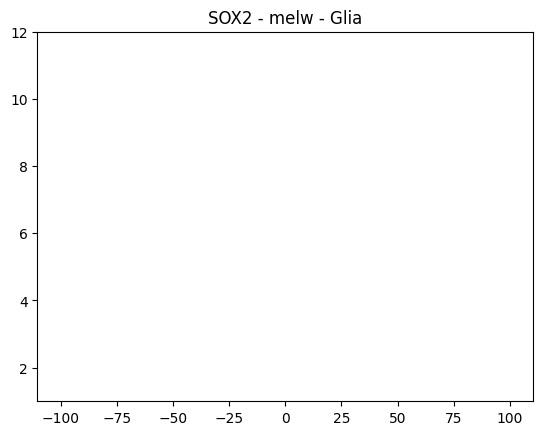

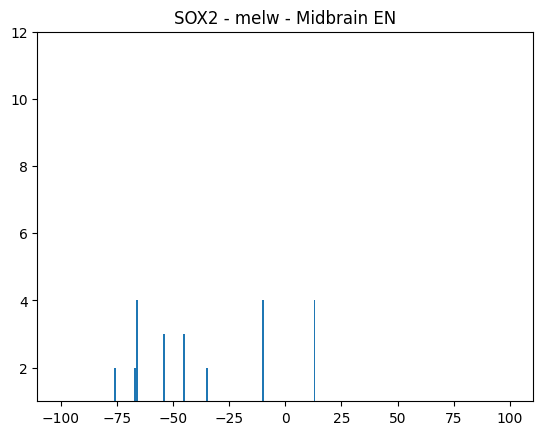

Region: SOX2, donor: melw, cell type: UL-EN --> No fragments found


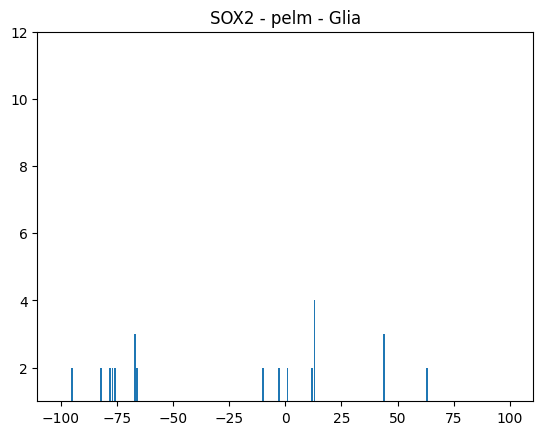

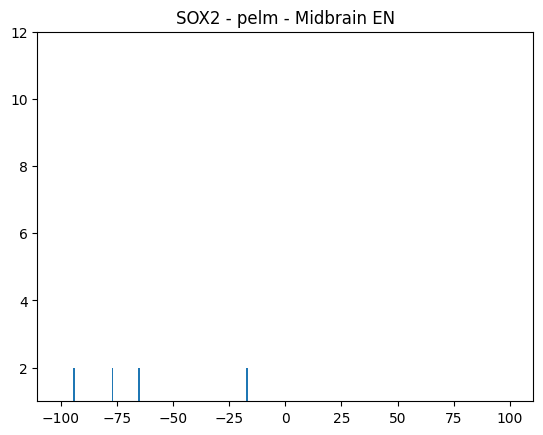

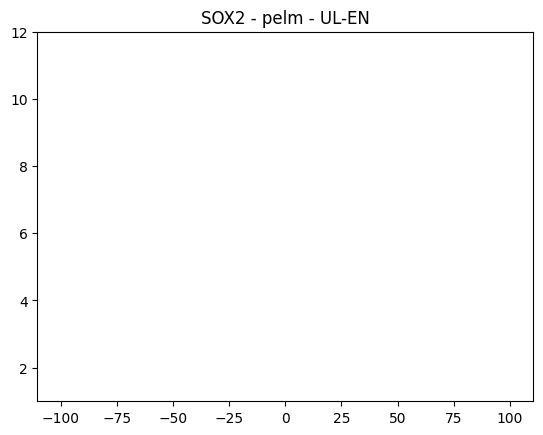

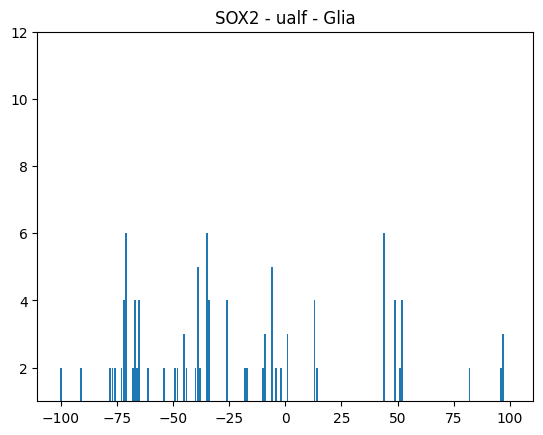

Region: SOX2, donor: ualf, cell type: Midbrain EN --> No fragments found


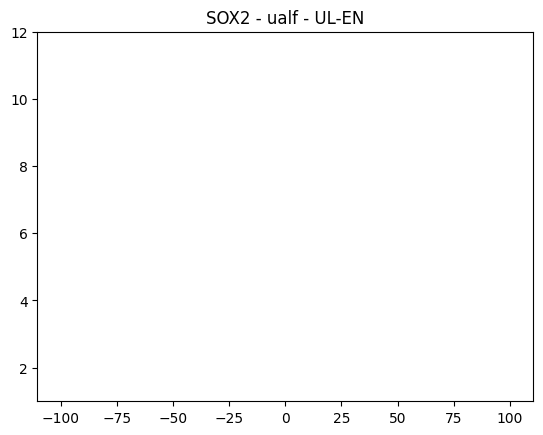

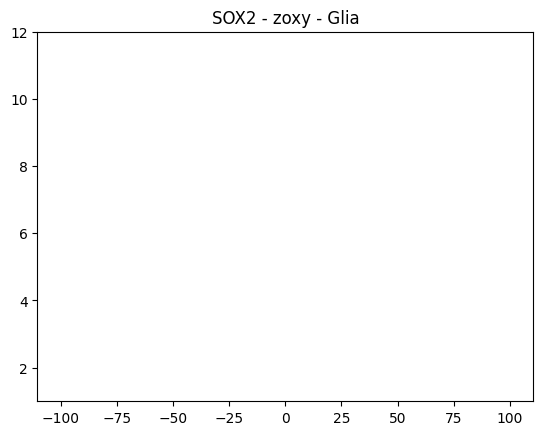

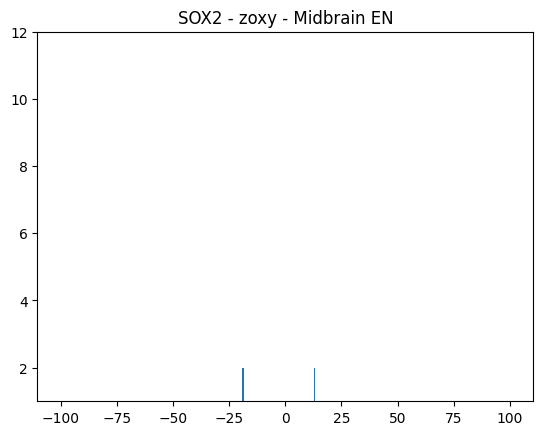

Region: SOX2, donor: zoxy, cell type: UL-EN --> No fragments found
Region: LHX5, donor: melw, cell type: Glia --> No fragments found


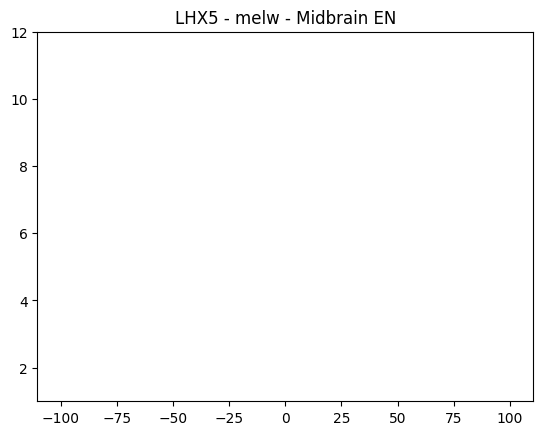

Region: LHX5, donor: melw, cell type: UL-EN --> No fragments found


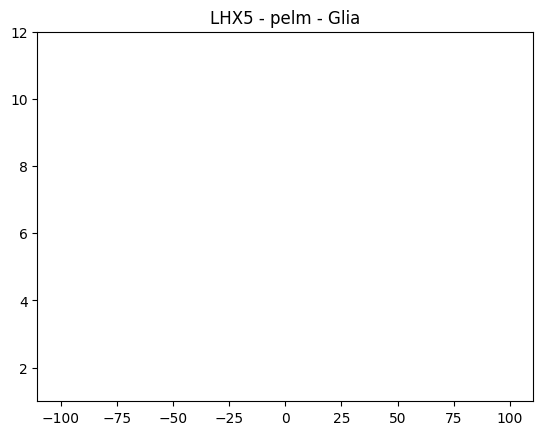

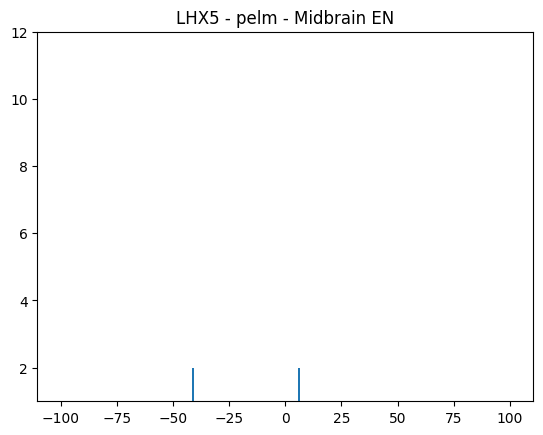

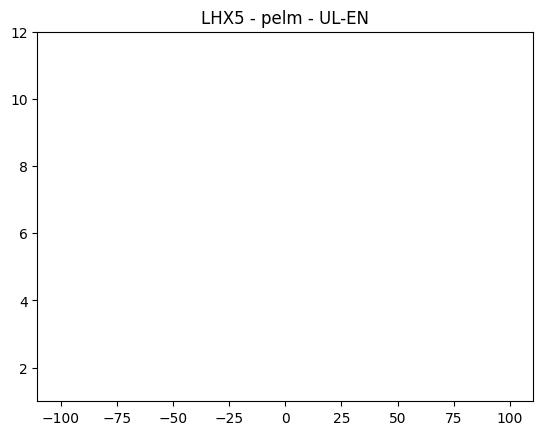

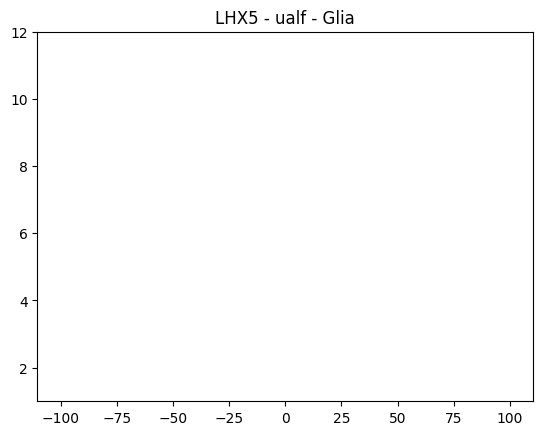

Region: LHX5, donor: ualf, cell type: Midbrain EN --> No fragments found


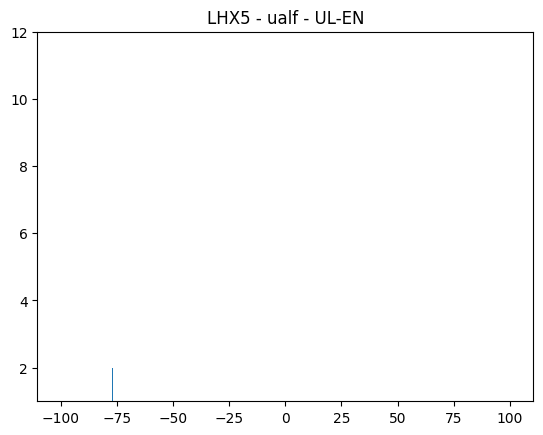

Region: LHX5, donor: zoxy, cell type: Glia --> No fragments found


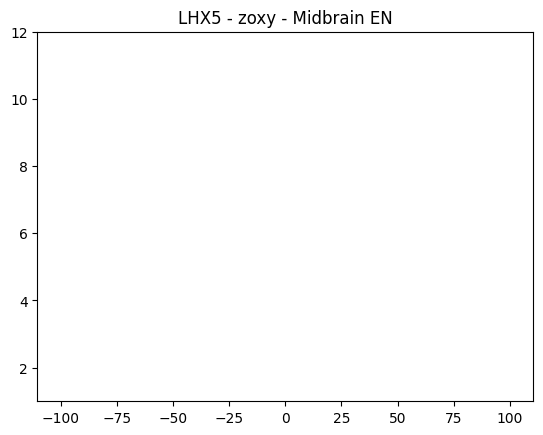

Region: LHX5, donor: zoxy, cell type: UL-EN --> No fragments found


In [17]:
for r in profiles.keys():
    
    for d in q_donors:
        
        for ct in q_ct:
    
            if profiles[r][d][ct]:

                lenth = len(profiles[r][d][ct]['profile'])
                plt.bar(np.linspace(-(lenth // 2), lenth // 2, lenth), profiles[r][d][ct]['profile'])
                plt.xlim([-(lenth // 2), lenth // 2])
                plt.ylim([0,12])
                plt.title(f"{r} - {d} - {ct}")
                plt.show()
                
            else:
                print(f'Region: {r}, donor: {d}, cell type: {ct} --> No fragments found')

## Count counts

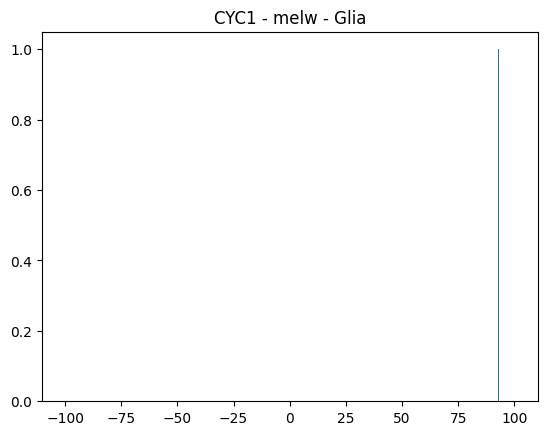

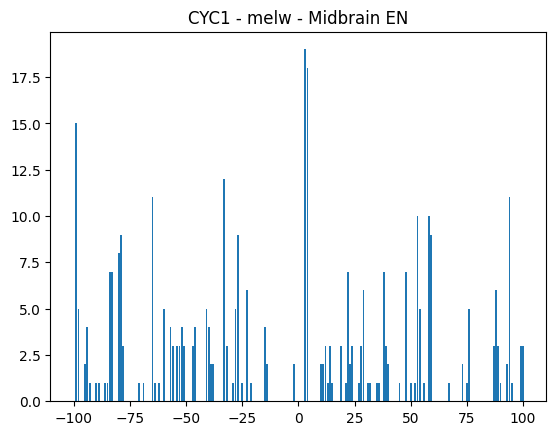

Region: CYC1, donor: melw, cell type: UL-EN --> No fragments found


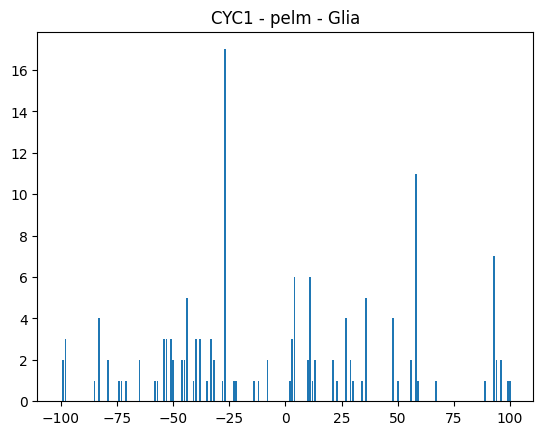

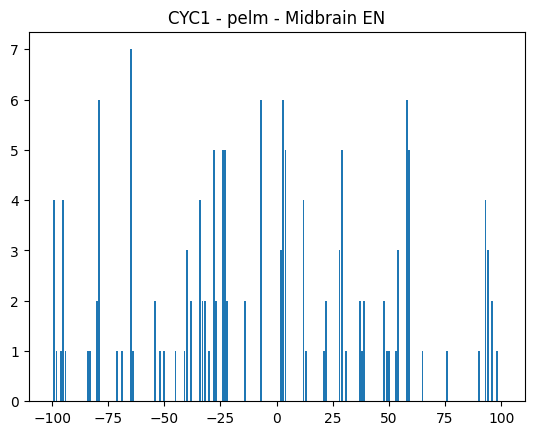

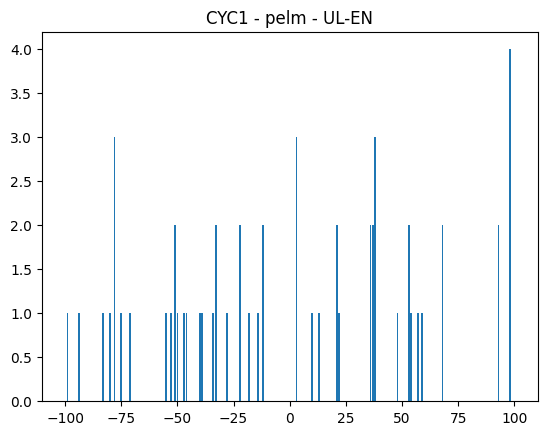

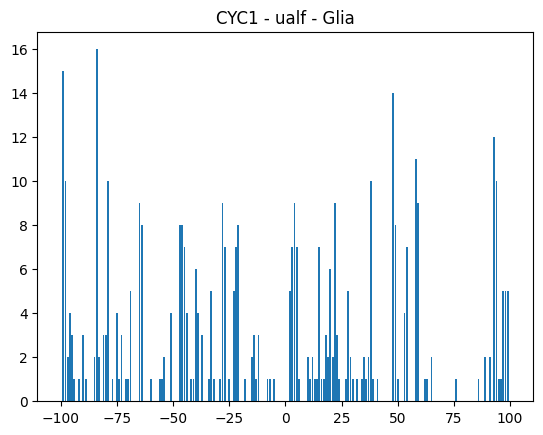

Region: CYC1, donor: ualf, cell type: Midbrain EN --> No fragments found


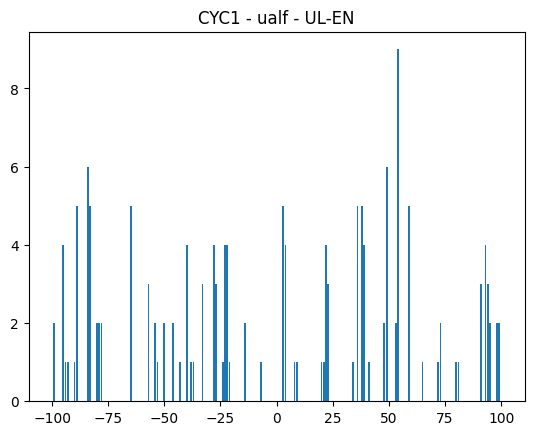

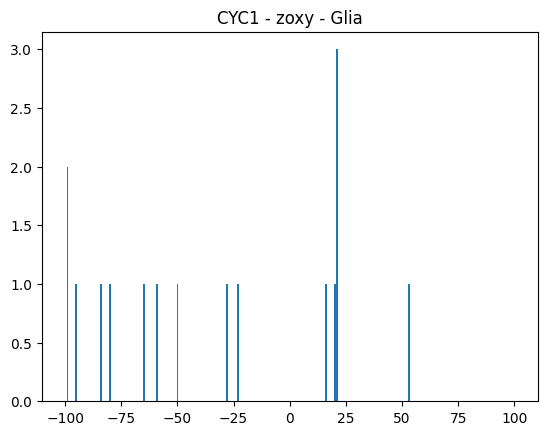

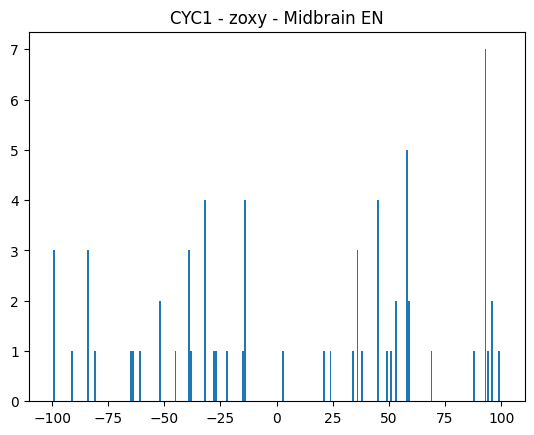

Region: CYC1, donor: zoxy, cell type: UL-EN --> No fragments found
Region: RPL13, donor: melw, cell type: Glia --> No fragments found


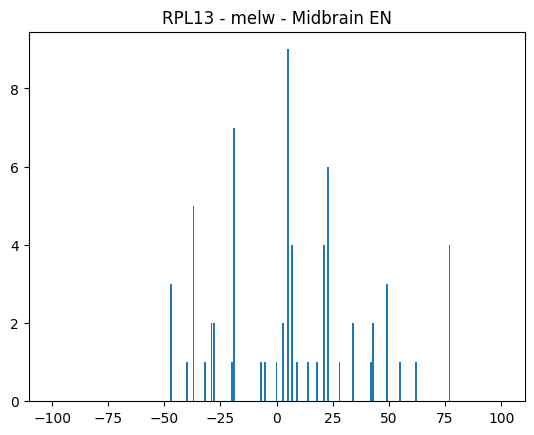

Region: RPL13, donor: melw, cell type: UL-EN --> No fragments found


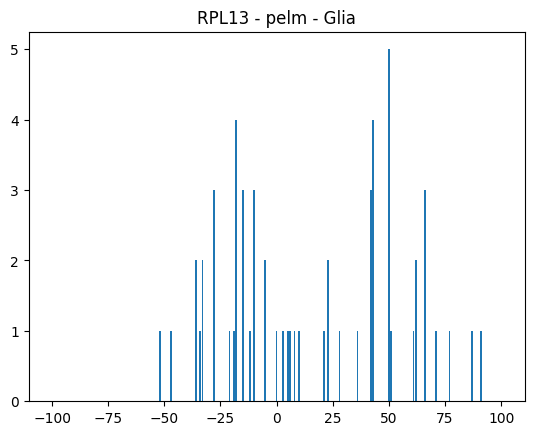

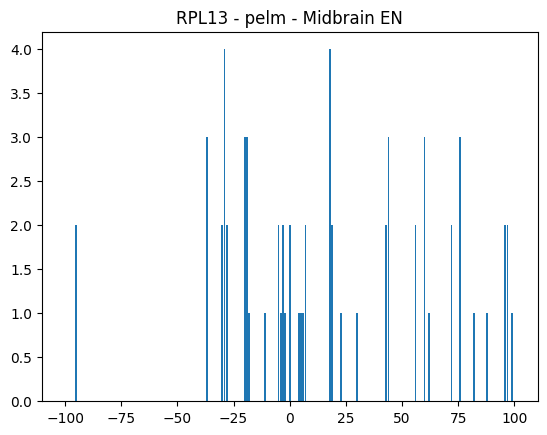

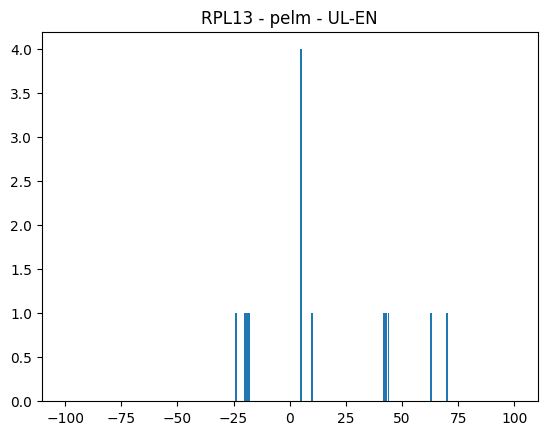

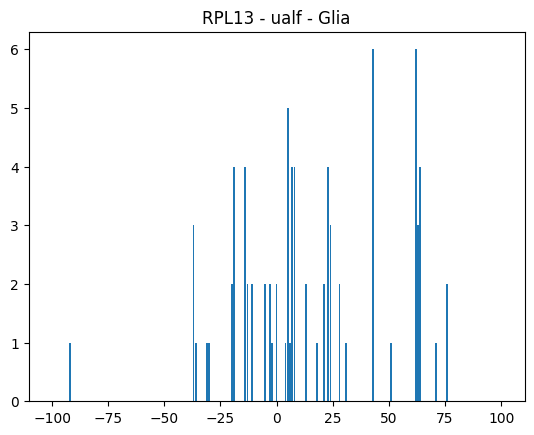

Region: RPL13, donor: ualf, cell type: Midbrain EN --> No fragments found


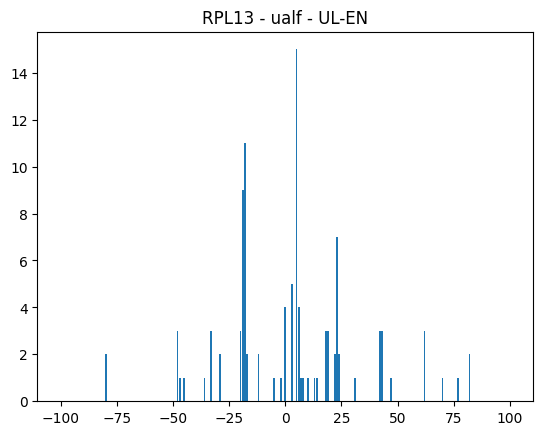

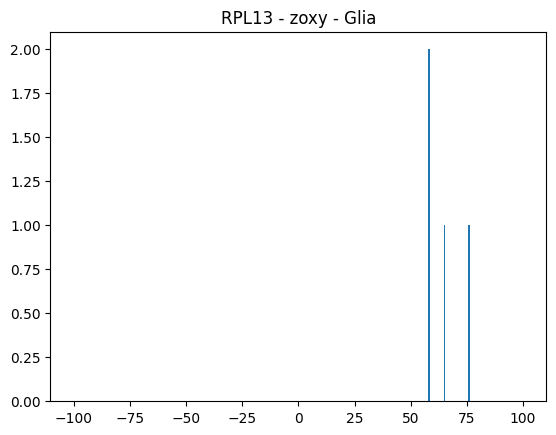

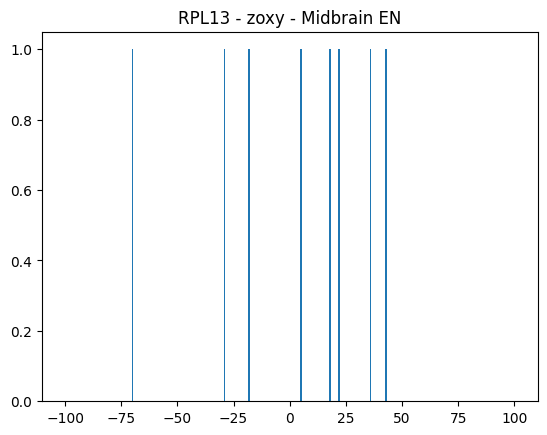

Region: RPL13, donor: zoxy, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: melw, cell type: Glia --> No fragments found
Region: MEF2C, donor: melw, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: melw, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: pelm, cell type: Glia --> No fragments found
Region: MEF2C, donor: pelm, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: pelm, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: ualf, cell type: Glia --> No fragments found
Region: MEF2C, donor: ualf, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: ualf, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: zoxy, cell type: Glia --> No fragments found
Region: MEF2C, donor: zoxy, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: zoxy, cell type: UL-EN --> No fragments found


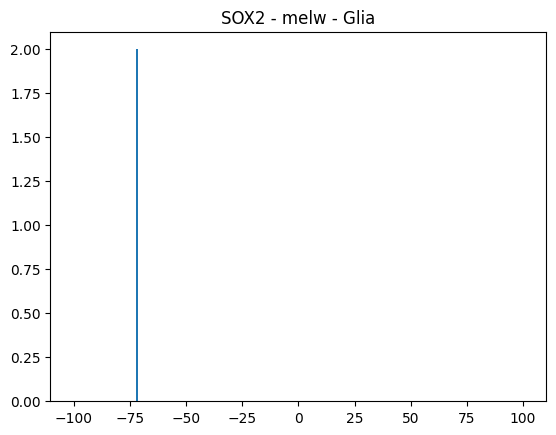

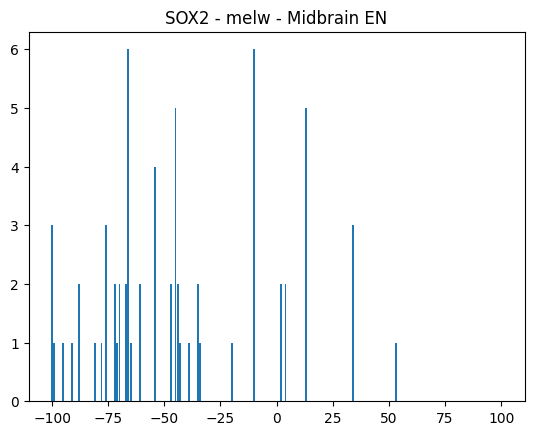

Region: SOX2, donor: melw, cell type: UL-EN --> No fragments found


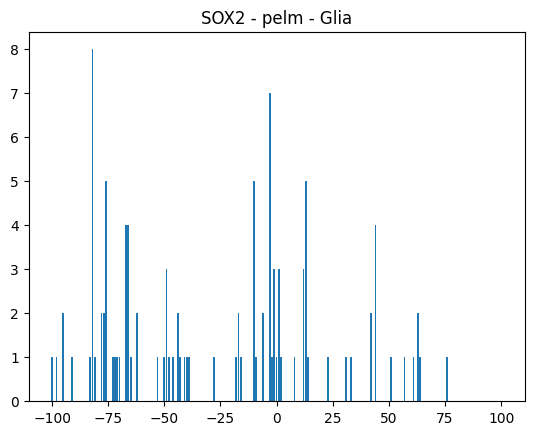

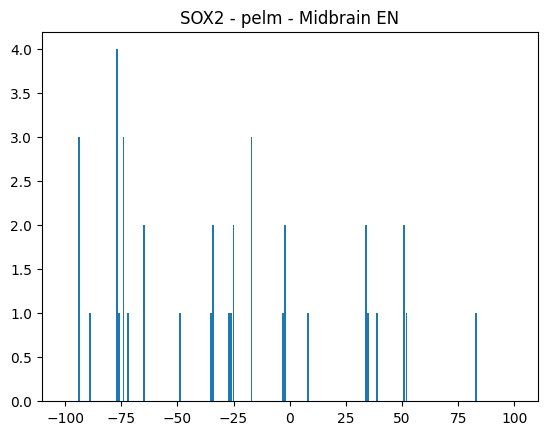

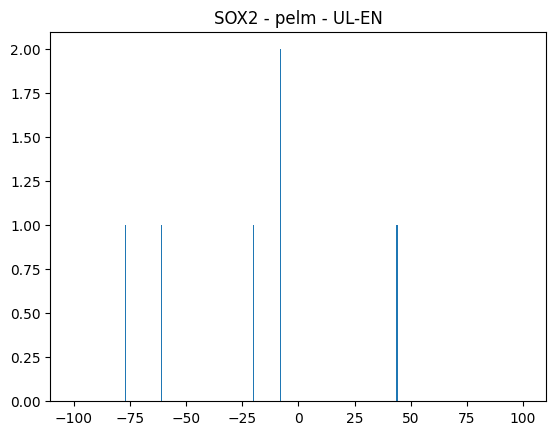

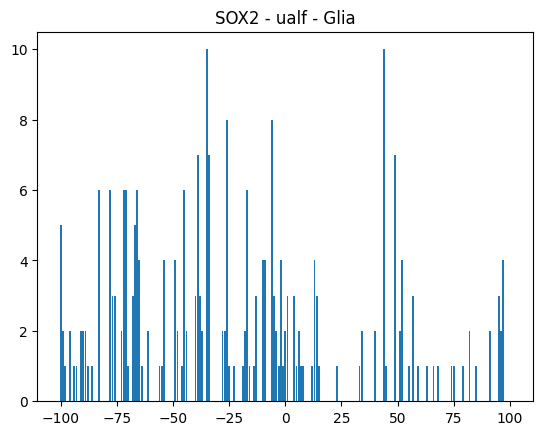

Region: SOX2, donor: ualf, cell type: Midbrain EN --> No fragments found


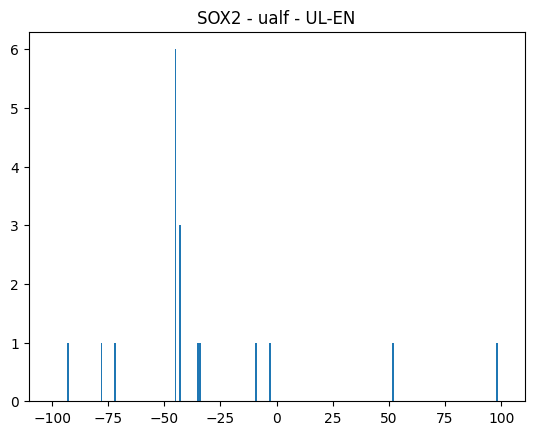

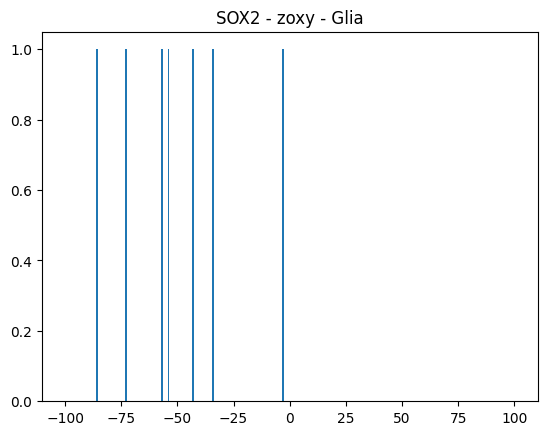

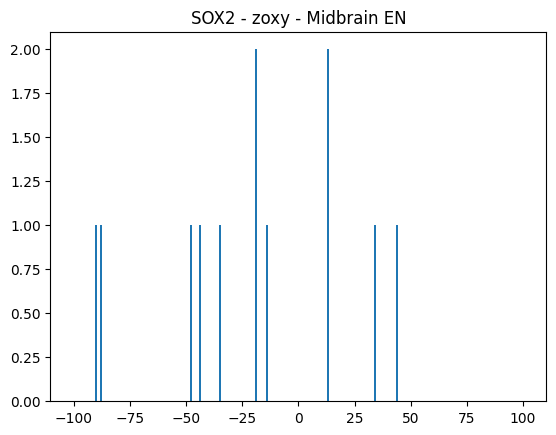

Region: SOX2, donor: zoxy, cell type: UL-EN --> No fragments found
Region: LHX5, donor: melw, cell type: Glia --> No fragments found


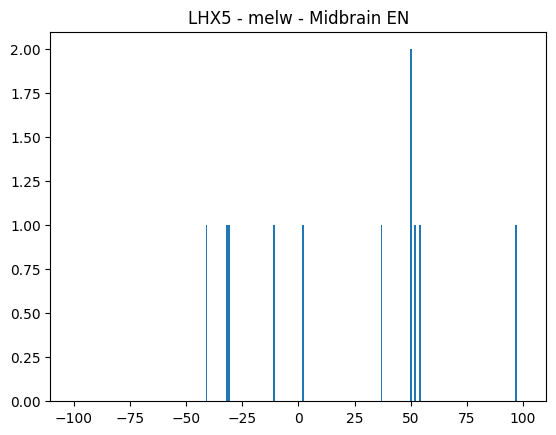

Region: LHX5, donor: melw, cell type: UL-EN --> No fragments found


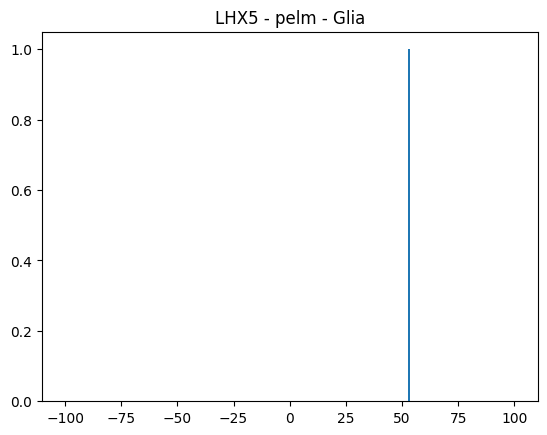

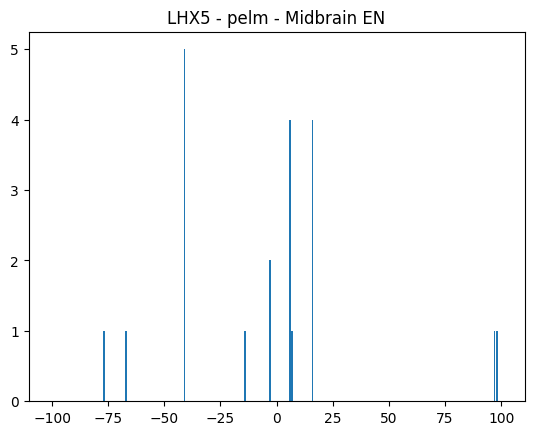

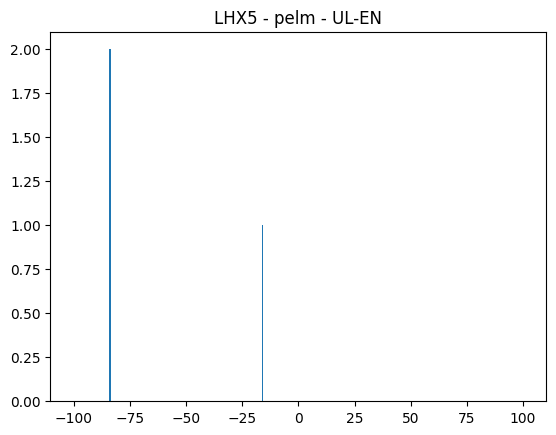

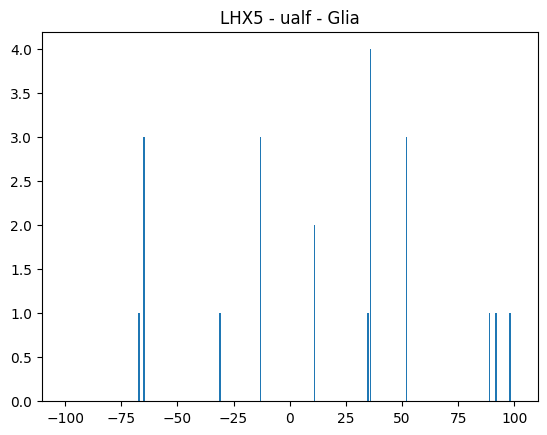

Region: LHX5, donor: ualf, cell type: Midbrain EN --> No fragments found


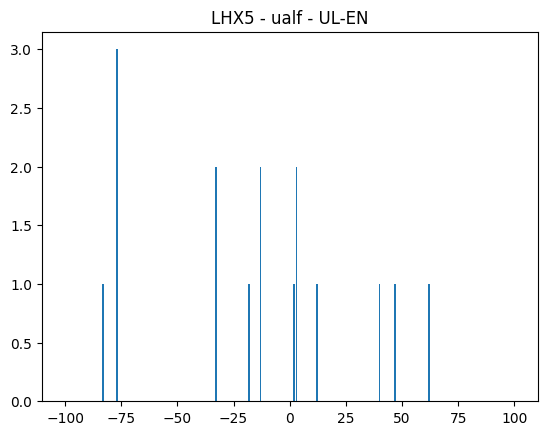

Region: LHX5, donor: zoxy, cell type: Glia --> No fragments found


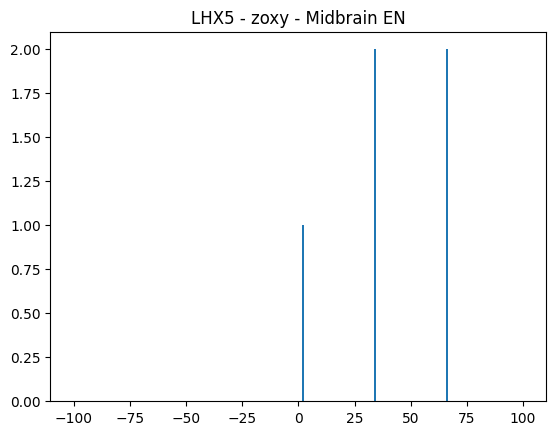

Region: LHX5, donor: zoxy, cell type: UL-EN --> No fragments found


In [18]:
for r in profiles_counts.keys():
    
    for d in q_donors:
        
        for ct in q_ct:
    
            if profiles[r][d][ct]:

                lenth = len(profiles_counts[r][d][ct]['profile'])
                plt.bar(np.linspace(-(lenth // 2), lenth // 2, lenth), profiles_counts[r][d][ct]['profile'])
                plt.xlim([-(lenth // 2), lenth // 2])
                plt.ylim([0,12])
                plt.title(f"{r} - {d} - {ct}")
                plt.show()
                
            else:
                print(f'Region: {r}, donor: {d}, cell type: {ct} --> No fragments found')

## +4/-4

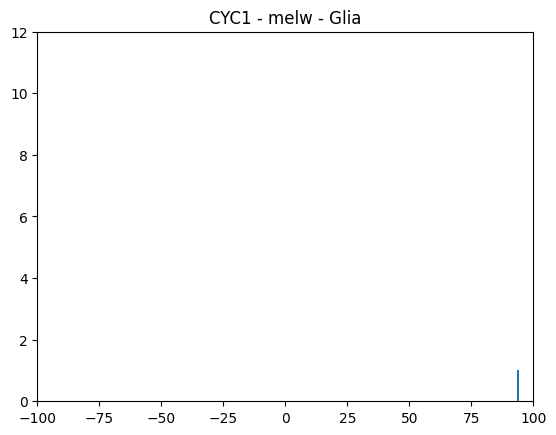

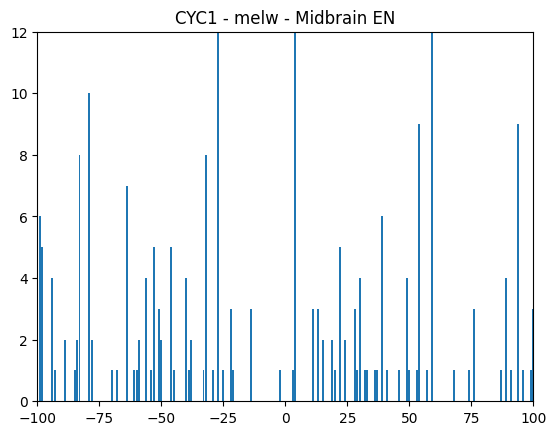

Region: CYC1, donor: melw, cell type: UL-EN --> No fragments found


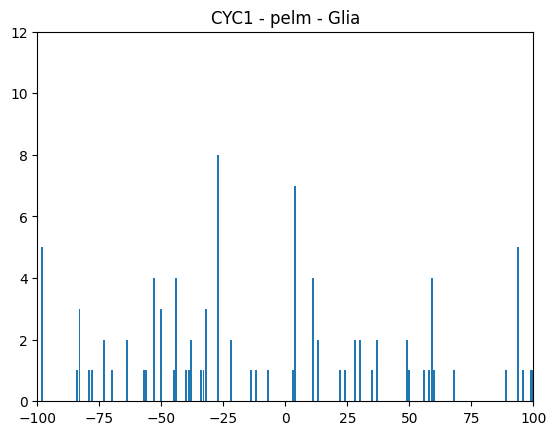

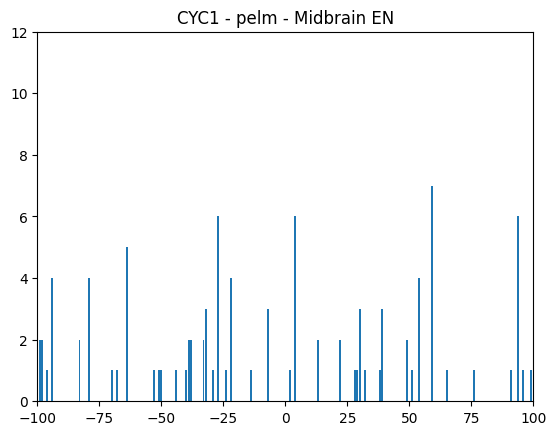

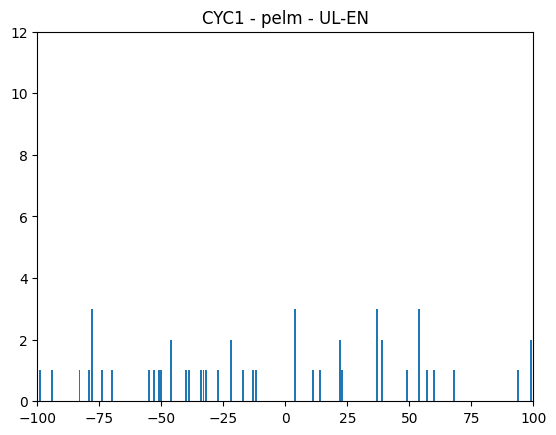

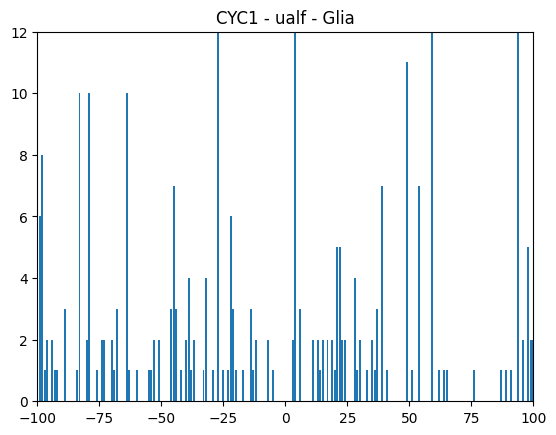

Region: CYC1, donor: ualf, cell type: Midbrain EN --> No fragments found


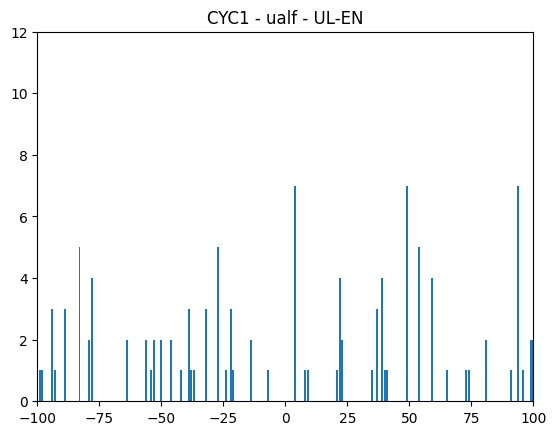

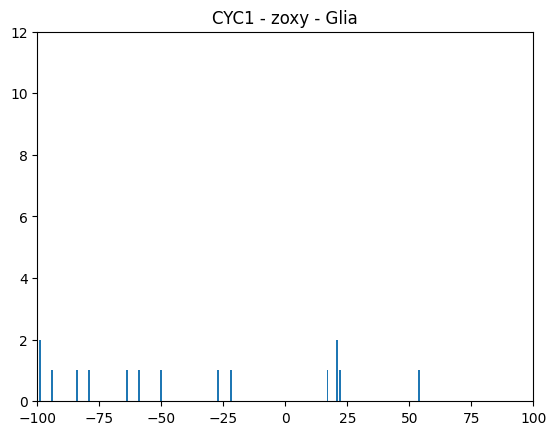

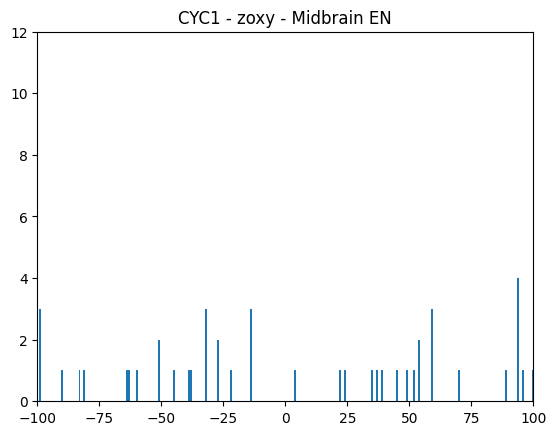

Region: CYC1, donor: zoxy, cell type: UL-EN --> No fragments found
Region: RPL13, donor: melw, cell type: Glia --> No fragments found


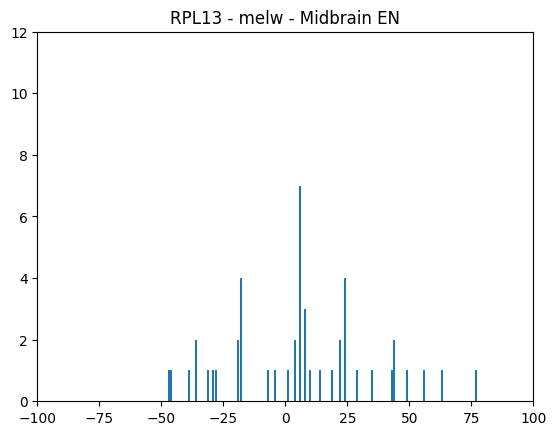

Region: RPL13, donor: melw, cell type: UL-EN --> No fragments found


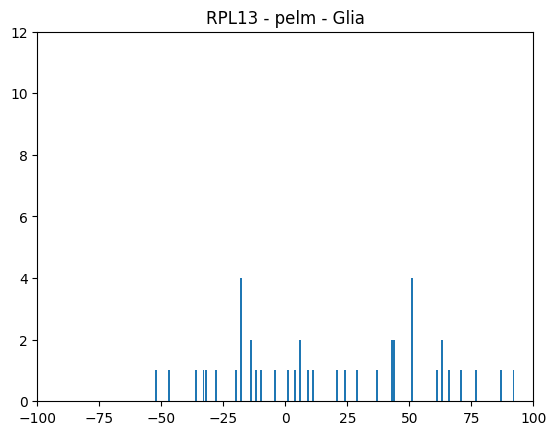

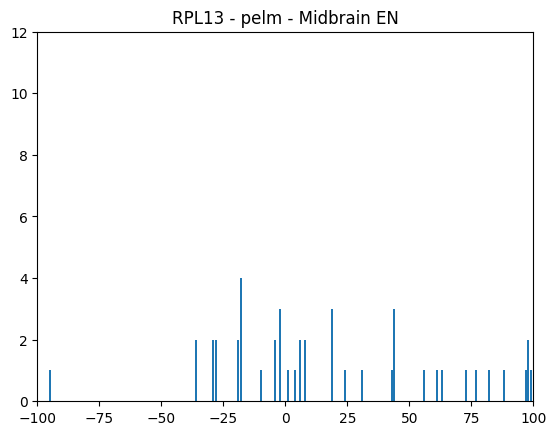

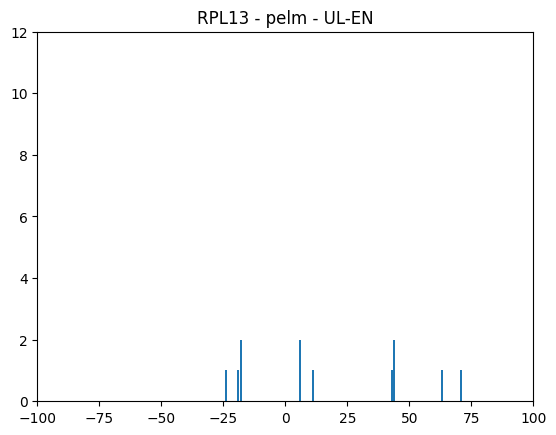

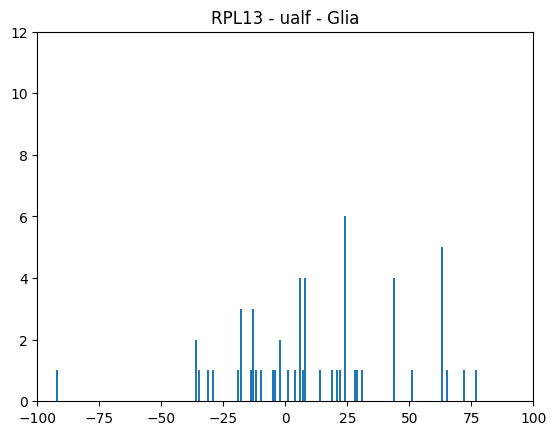

Region: RPL13, donor: ualf, cell type: Midbrain EN --> No fragments found


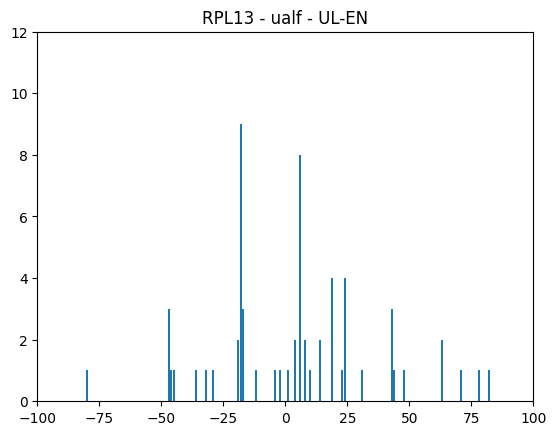

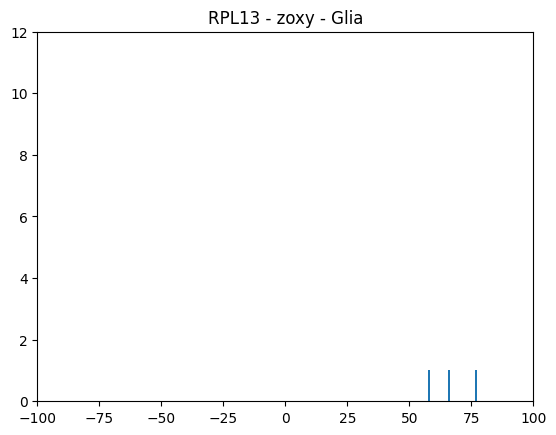

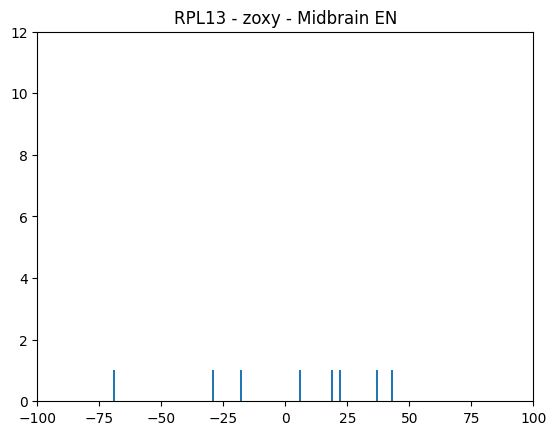

Region: RPL13, donor: zoxy, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: melw, cell type: Glia --> No fragments found
Region: MEF2C, donor: melw, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: melw, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: pelm, cell type: Glia --> No fragments found
Region: MEF2C, donor: pelm, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: pelm, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: ualf, cell type: Glia --> No fragments found
Region: MEF2C, donor: ualf, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: ualf, cell type: UL-EN --> No fragments found
Region: MEF2C, donor: zoxy, cell type: Glia --> No fragments found
Region: MEF2C, donor: zoxy, cell type: Midbrain EN --> No fragments found
Region: MEF2C, donor: zoxy, cell type: UL-EN --> No fragments found


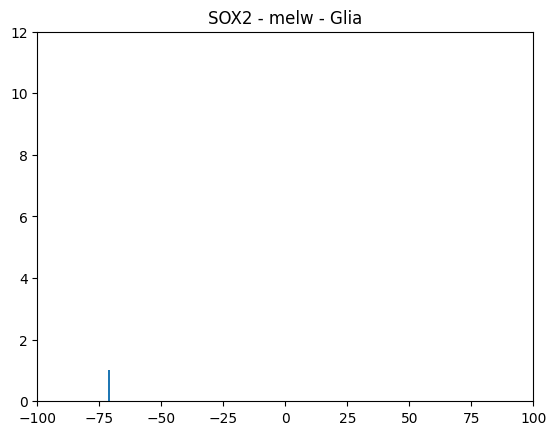

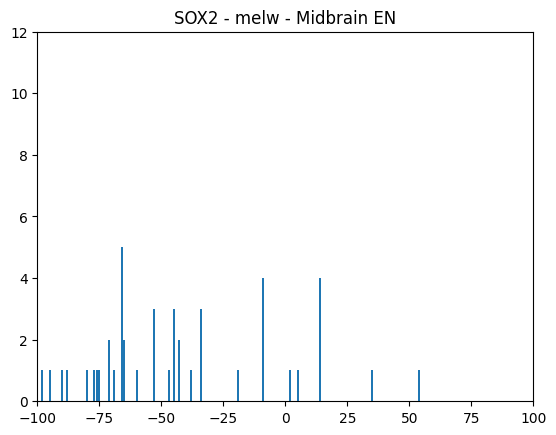

Region: SOX2, donor: melw, cell type: UL-EN --> No fragments found


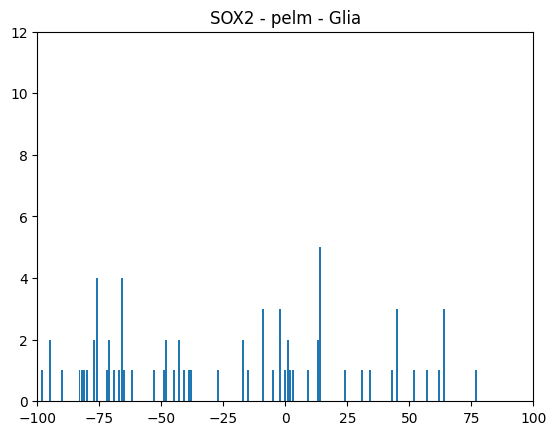

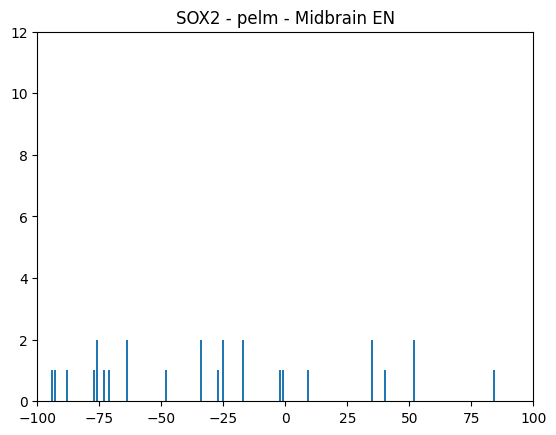

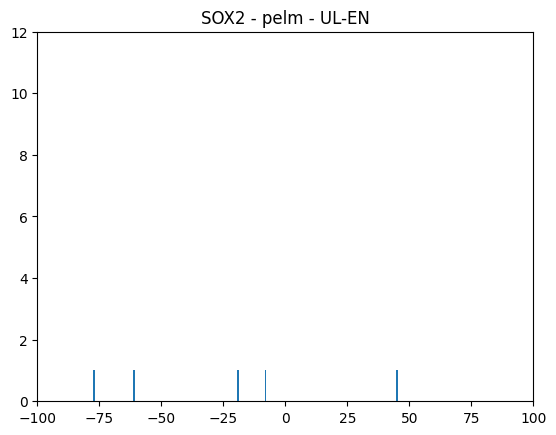

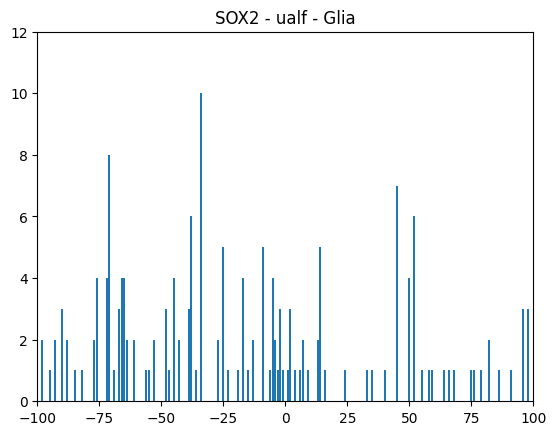

Region: SOX2, donor: ualf, cell type: Midbrain EN --> No fragments found


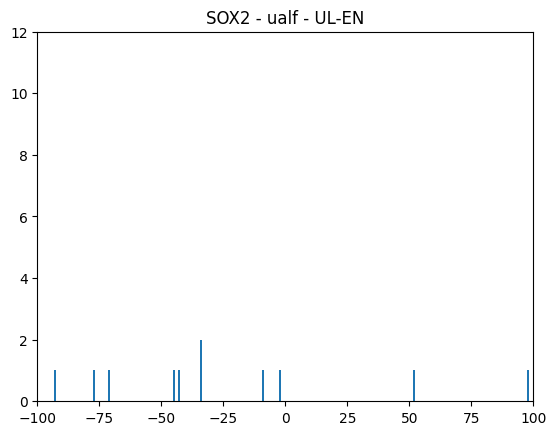

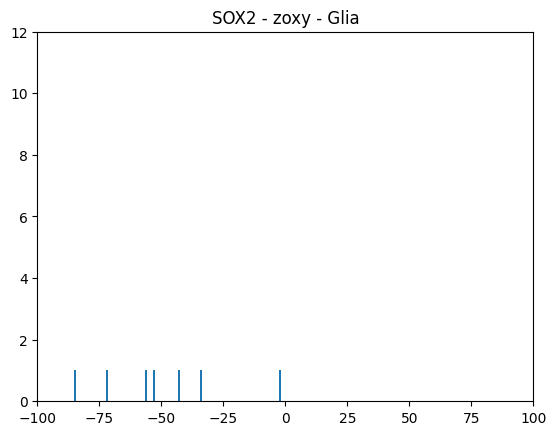

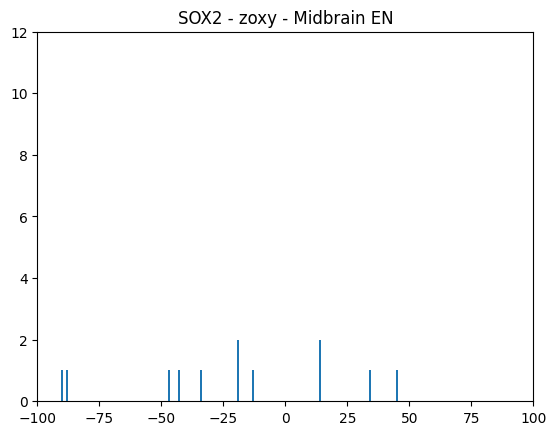

Region: SOX2, donor: zoxy, cell type: UL-EN --> No fragments found
Region: LHX5, donor: melw, cell type: Glia --> No fragments found


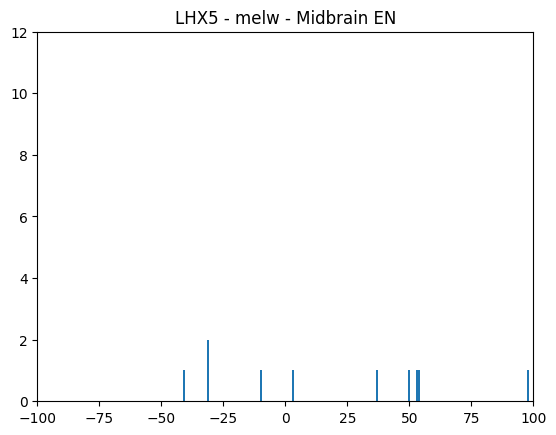

Region: LHX5, donor: melw, cell type: UL-EN --> No fragments found


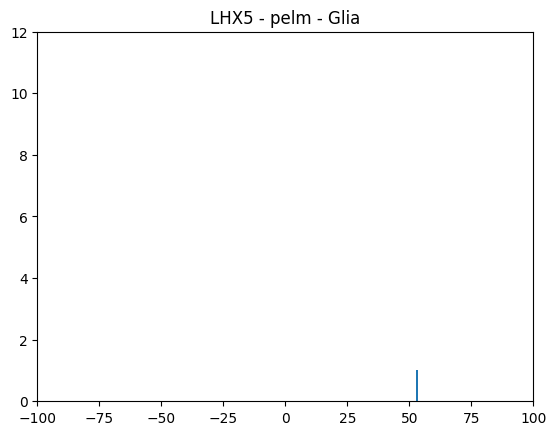

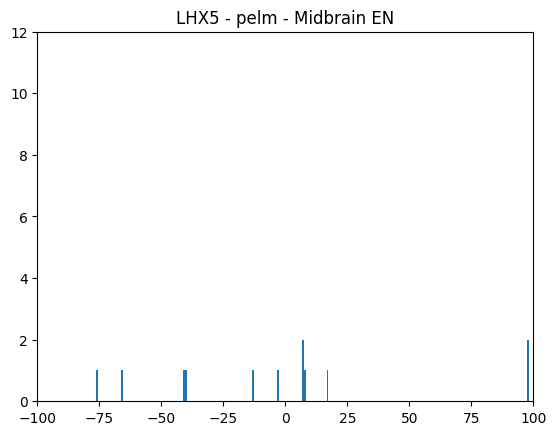

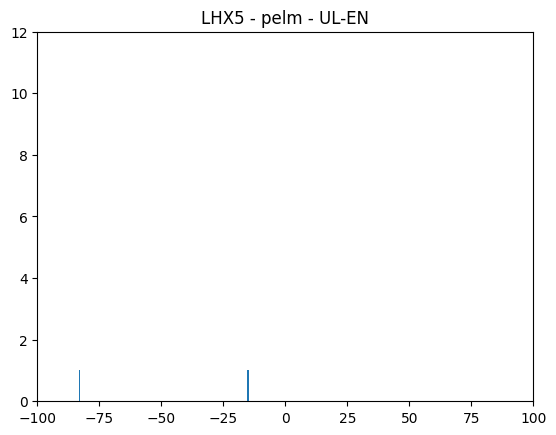

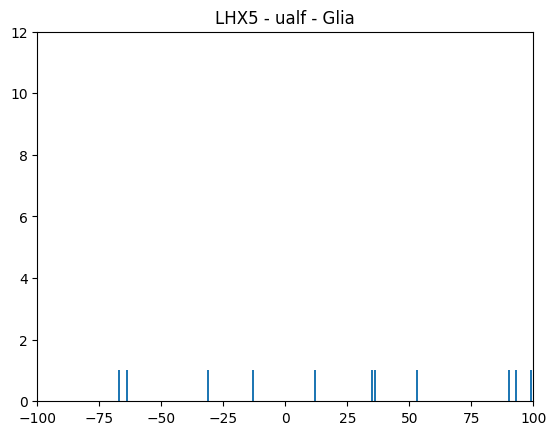

Region: LHX5, donor: ualf, cell type: Midbrain EN --> No fragments found


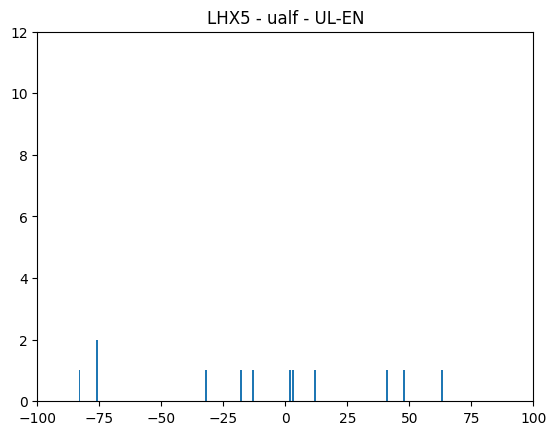

Region: LHX5, donor: zoxy, cell type: Glia --> No fragments found


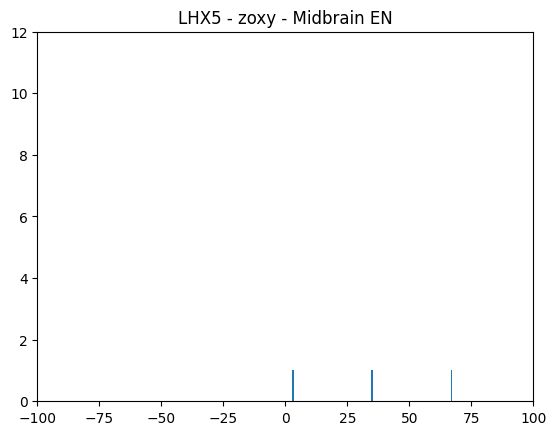

Region: LHX5, donor: zoxy, cell type: UL-EN --> No fragments found


In [19]:
for r in profiles_cbn.keys():
    
    for d in q_donors:
        
        for ct in q_ct:
    
            if profiles[r][d][ct]:

                lenth = len(profiles_cbn[r][d][ct]['profile'])
                plt.bar(np.linspace(-(lenth // 2), lenth // 2, lenth), profiles_cbn[r][d][ct]['profile'])
                plt.xlim([-(lenth // 2), lenth // 2])
                plt.ylim([0,12])
                plt.title(f"{r} - {d} - {ct}")
                plt.show()
                
            else:
                print(f'Region: {r}, donor: {d}, cell type: {ct} --> No fragments found')